In [289]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost 

In [290]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [291]:
train = pd.read_csv('train.csv')

Drop outliers:

In [292]:
out_index = train[(train.GrLivArea > 4000) & (train.SalePrice < 200000)].index

In [293]:
train.drop(out_index, axis=0, inplace=True)

In [294]:
#train = train[train['GrLivArea'] <= 4000]
train.loc[train['LotArea'] > 30000, 'LotArea'] = 30000

FillNA

In [295]:
for col in train.columns:
    if train[col].dtype == 'object':
        train[col].fillna('N_A', inplace=True)
    else:
        train[col].fillna(0, inplace=True)

Feature conversion:

In [296]:
mapping = {'N_A': 0, 
           'Po': 1, 
           'Fa': 2, 
           'TA': 3, 
           'Gd': 4, 
           'Ex': 5}

In [297]:
for col in train.columns:
    if train[col].unique().any() in ['TA', 'Gd', 'Fa', 'Po', 'Ex']:
        train[col] = train[col].map(mapping)

In [298]:
train['FireplaceQu'] = train['FireplaceQu'].map(mapping)

Drop unnecessaries

In [299]:
train.drop('Id', axis=1, inplace=True)

In [300]:
train.drop('LotFrontage', axis=1, inplace=True)

In [301]:
train

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,N_A,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,No,GLQ,706,Unf,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0,Attchd,2003.0,RFn,2,548,3,3,Y,0,61,0,0,0,0,N_A,N_A,N_A,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,N_A,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,Gd,ALQ,978,Unf,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3,Attchd,1976.0,RFn,2,460,3,3,Y,298,0,0,0,0,0,N_A,N_A,N_A,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,N_A,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,Mn,GLQ,486,Unf,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3,Attchd,2001.0,RFn,2,608,3,3,Y,0,42,0,0,0,0,N_A,N_A,N_A,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,N_A,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,No,ALQ,216,Unf,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4,Detchd,1998.0,Unf,3,642,3,3,Y,0,35,272,0,0,0,N_A,N_A,N_A,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,N_A,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,Av,GLQ,655,Unf,0,490,1145,GasA,5,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3,Attchd,2000.0,RFn,3,836,3,3,Y,192,84,0,0,0,0,N_A,N_A,N_A,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,N_A,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4,3,No,Unf,0,Unf,0,953,953,GasA,5,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,3,7,Typ,1,3,Attchd,1999.0,RFn,2,460,3,3,Y,0,40,0,0,0,0,N_A,N_A,N_A,0,8,2007,WD,Normal,175000
1456,20,RL,13175,Pave,N_A,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,3,3,CBlock,4,3,No,ALQ,790,Rec,163,589,1542,GasA,3,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,3,7,Min1,2,3,Attchd,1978.0,Unf,2,500,3,3,Y,349,0,0,0,0,0,N_A,MnPrv,N_A,0,2,2010,WD,Normal,210000
1457,70,RL,9042,Pave,N_A,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,5,4,Stone,3,4,No,GLQ,275,Unf,0,877,1152,GasA,5,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,4,9,Typ,2,4,Attchd,1941.0,RFn,1,252,3,3,Y,0,60,0,0,0,0,N_A,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,9717,Pave,N_A,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,3,3,Mn,GLQ,49,Rec,1029,0,1078,GasA,4,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,4,5,Typ,0,0,Attchd,1950.0,Unf,1,240,3,3,Y,366,0,112,0,0,0,N_A,N_A,N_A,0,4,2010,WD,Normal,142125


Transformation into ordinal feature:

In [302]:
neighborhoods = (train.groupby('Neighborhood')['SalePrice']
                 .agg(['mean', 'median', 'count'])
                 .sort_values(by='median', ascending=False))

In [303]:
n_sorted = neighborhoods.sort_values(by='median').index

In [304]:
for i, n in enumerate(n_sorted):
    train.loc[train['Neighborhood'] == n, 'neighborhoods_ordinal'] = int(i+1)

In [305]:
train.drop('Neighborhood', axis=1, inplace=True)

In [306]:
#train['AreaQual'] = np.log(train['AreaQual'])
#train['DeckPorchSF'] = np.log(train['DeckPorchSF'])
#train['TotalLivingSF'] = np.log(train['TotalLivingSF'])
#train['SalePrice'] = np.log(train['SalePrice'])

### Modeling

In [481]:
def extract_cat_features(data):
    cat_features = []
    num_features = []
    for i, col in enumerate(data.columns):
        if data[col].dtype == 'object':
            cat_features.append(col)
        else:
            num_features.append(col)
    return cat_features, num_features

In [482]:
def prepare_and_split_data(input_data, test_size=0):
    data = input_data.copy()
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col].fillna('N_A', inplace=True)
        else:
            data[col].fillna(0, inplace=True)
    X = data.drop('SalePrice', axis=1)
    y = data['SalePrice']
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        return X_train, X_test, y_train, y_test
    else:
        return X, y

In [483]:
cat_features, num_features = extract_cat_features(train)

In [484]:
X_train, X_test, y_train, y_test = prepare_and_split_data(train, test_size=.25)

In [485]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)

eval_pool = Pool(X_test, 
                 y_test, 
                 cat_features=cat_features)

# specify the training parameters 
model = CatBoostRegressor(iterations=1000, 
                          depth=2, 
                          learning_rate=0.1, 
                          loss_function='MAE',
                          l2_leaf_reg=5,
                          one_hot_max_size=30,
                          random_state=42,
                          random_strength=1,                          
                          verbose=100
                          )
#train the model
model.fit(train_pool, eval_set=eval_pool)
# make the prediction using the resulting model
preds = model.predict(eval_pool)
print(f'RMSE: {np.sqrt(mean_squared_error(preds, y_test))}')
print(f'LRMSE: {np.sqrt(mean_squared_log_error(preds, y_test))}')
print(f'R2: {r2_score(preds, y_test)}')

0:	learn: 52215.6394775	test: 52890.9150171	best: 52890.9150171 (0)	total: 1.58ms	remaining: 1.58s
100:	learn: 15244.4544278	test: 16286.9045128	best: 16278.1440864 (98)	total: 116ms	remaining: 1.03s
200:	learn: 12915.3986154	test: 15254.9031813	best: 15254.9031813 (200)	total: 239ms	remaining: 950ms
300:	learn: 11903.3799953	test: 14849.6729582	best: 14847.8364001 (299)	total: 355ms	remaining: 823ms
400:	learn: 11251.2725892	test: 14668.0637213	best: 14655.0590792 (390)	total: 461ms	remaining: 688ms
500:	learn: 10793.9820364	test: 14497.7179588	best: 14494.6637828 (499)	total: 561ms	remaining: 559ms
600:	learn: 10328.1927707	test: 14352.7593171	best: 14351.7820086 (599)	total: 667ms	remaining: 443ms
700:	learn: 10052.2082395	test: 14311.0494876	best: 14311.0494876 (700)	total: 768ms	remaining: 328ms
800:	learn: 9715.1984317	test: 14174.1808572	best: 14174.1808572 (800)	total: 879ms	remaining: 218ms
900:	learn: 9482.6172438	test: 14116.3371660	best: 14107.0297143 (848)	total: 983ms	rem

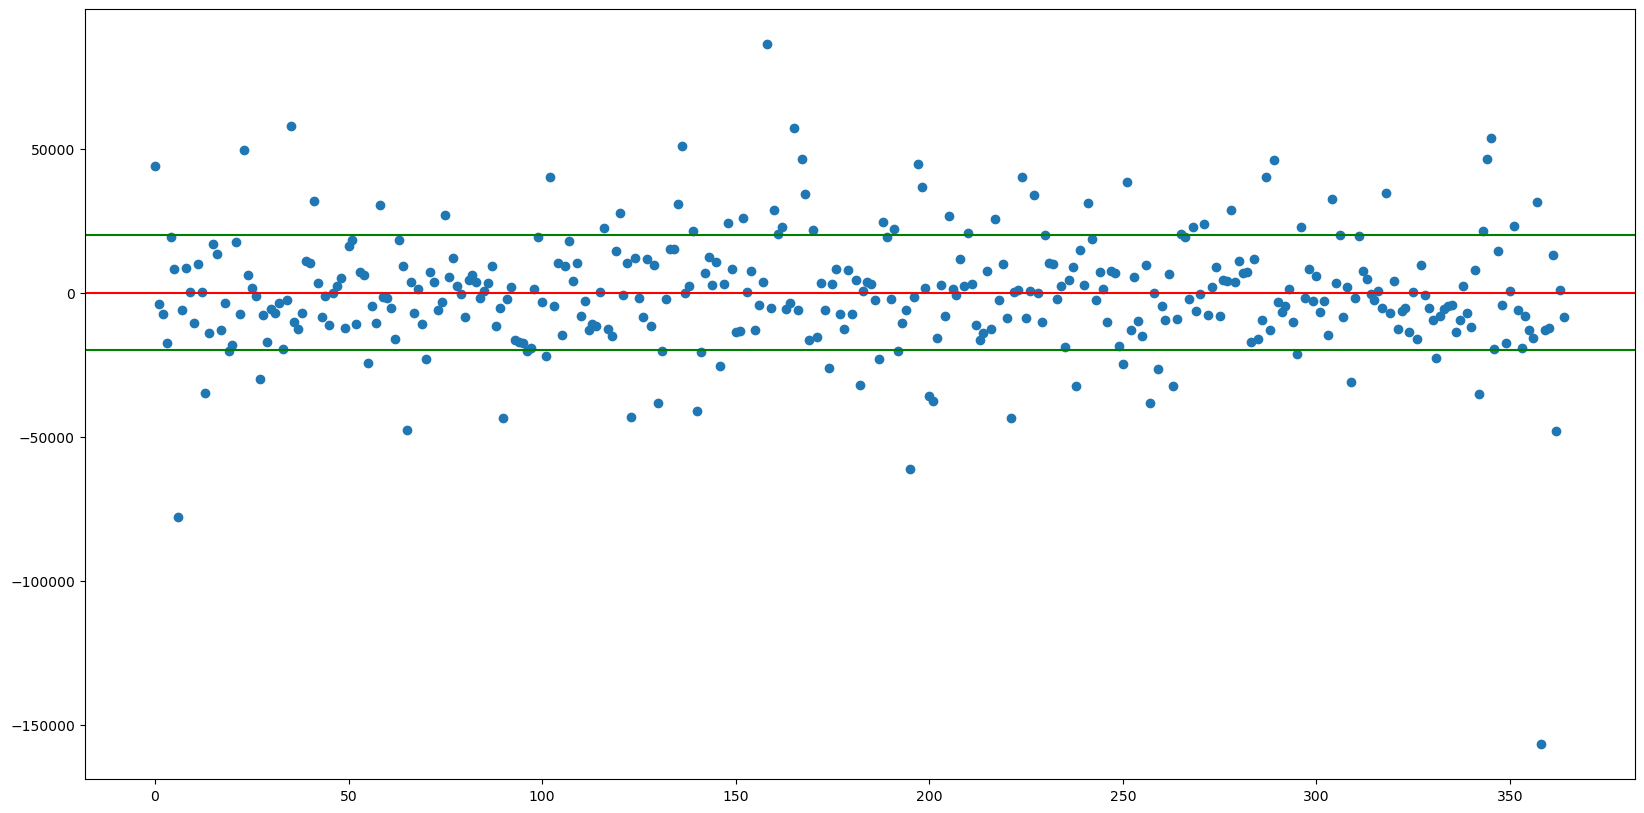

In [486]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(preds)), (preds - y_test))
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

In [487]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,GrLivArea,19.178299
1,OverallQual,17.149080
2,neighborhoods_ordinal,10.817781
3,ExterQual,5.907347
4,TotalBsmtSF,5.752781
5,1stFlrSF,4.538599
6,KitchenQual,3.828896
7,BsmtQual,3.696430
8,BsmtFinSF1,3.670921
9,GarageCars,3.172961


In [189]:
def data_preprocessing(data_train, test_size=0):
    X_train, X_test, y_train, y_test = train_test_split(data_train.drop('SalePrice', axis=1), 
                                                        data_train['SalePrice'], 
                                                        test_size=test_size, 
                                                        random_state=42)
    categories = []
    for col in data_train.columns:
        if data_train[col].dtype == 'object':
            categories.append(col)
    ohe = OneHotEncoder(handle_unknown='ignore')#(handle_unknown='infrequent_if_exist')
    ohe.fit(X_train[categories])
    cat_features_df = pd.DataFrame(ohe.transform(X_train[categories]).toarray(), 
                                   index=X_train.index, 
                                   columns=ohe.get_feature_names_out())
    X_train.drop(categories, axis=1, inplace=True)
    X = X_train.join(cat_features_df)
    test_cat_features_df = pd.DataFrame(ohe.transform(X_test[categories]).toarray(), 
                                        index=X_test.index, 
                                        columns=ohe.get_feature_names_out())
    X_test.drop(categories, axis=1, inplace=True)
    X_t = X_test.join(test_cat_features_df)
    return X, X_t, y_train, y_test

In [121]:
X_train1, X_test1, y_train1, y_test1 = data_preprocessing(train, test_size=.25)

In [173]:
scaler = StandardScaler()

In [234]:
scaler.fit(X_train1)

StandardScaler()

In [175]:
X_train1_s = scaler.transform(X_train1)
X_test1_s = scaler.transform(X_test1)

In [125]:
y_train_log = np.log(y_train1)
y_test_log = np.log(y_test1)

In [126]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge

In [127]:
lasso = Lasso(alpha=10.0, 
      fit_intercept=True, 
      precompute=False, 
      copy_X=True, 
      max_iter=5000, 
      tol=0.0001, 
      warm_start=False, 
      positive=False, 
      random_state=42, 
      selection='random')

In [128]:
lasso.fit(X_train1_s, y_train1)

C:\Soft\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e+10, tolerance: 6.971e+08
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=10.0, max_iter=5000, random_state=42, selection='random')

In [129]:
lasso_preds = lasso.predict(X_test1_s)

In [130]:
np.sqrt(mean_squared_error(lasso.predict(X_test1_s), y_test1))

32260.565900546637

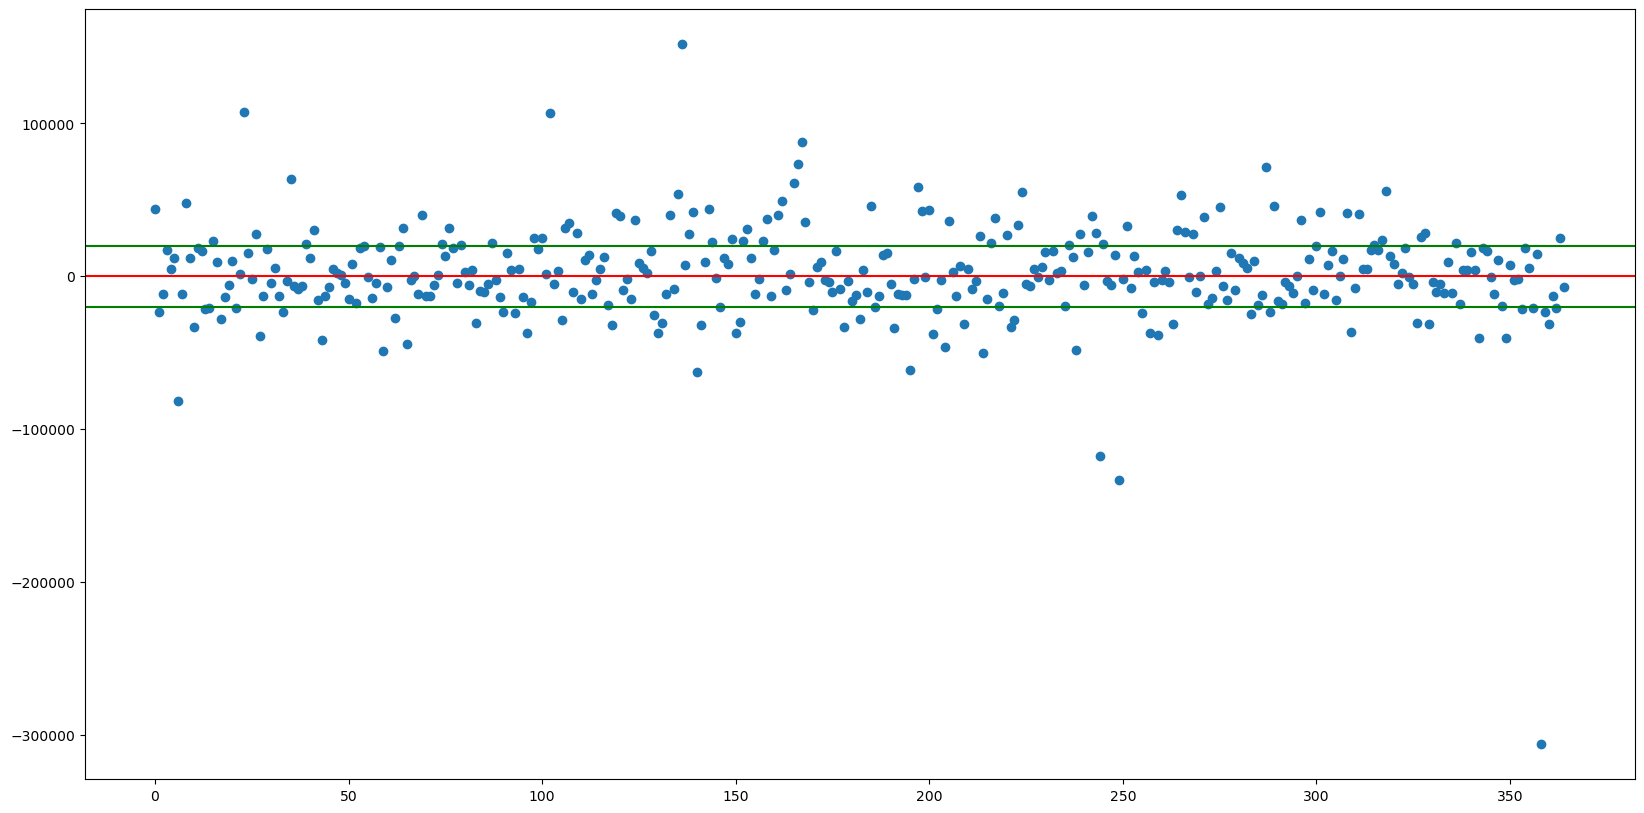

In [131]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(y_test1)), lasso.predict(X_test1_s) - y_test1)
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

### SVR

In [132]:
from sklearn.svm import SVR

In [133]:
svr = SVR(kernel='linear', 
          degree=1, 
          gamma='scale', 
          coef0=0.0, 
          tol=0.001, 
          C=300.0, 
          epsilon=0.1, 
          shrinking=True, 
          cache_size=200, 
          verbose=False, 
          max_iter=1000)

In [134]:
svr.fit(X_train1_s, y_train1)

C:\Soft\Anaconda\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR(C=300.0, degree=1, kernel='linear', max_iter=1000)

In [200]:
svr_preds = svr.predict(X_test1_s)

In [136]:
np.sqrt(mean_squared_error(svr.predict(X_test1_s), y_test1))

29480.38102246763

In [137]:
np.sqrt(mean_squared_log_error(svr.predict(X_test1_s), y_test1))

0.1620254882148868

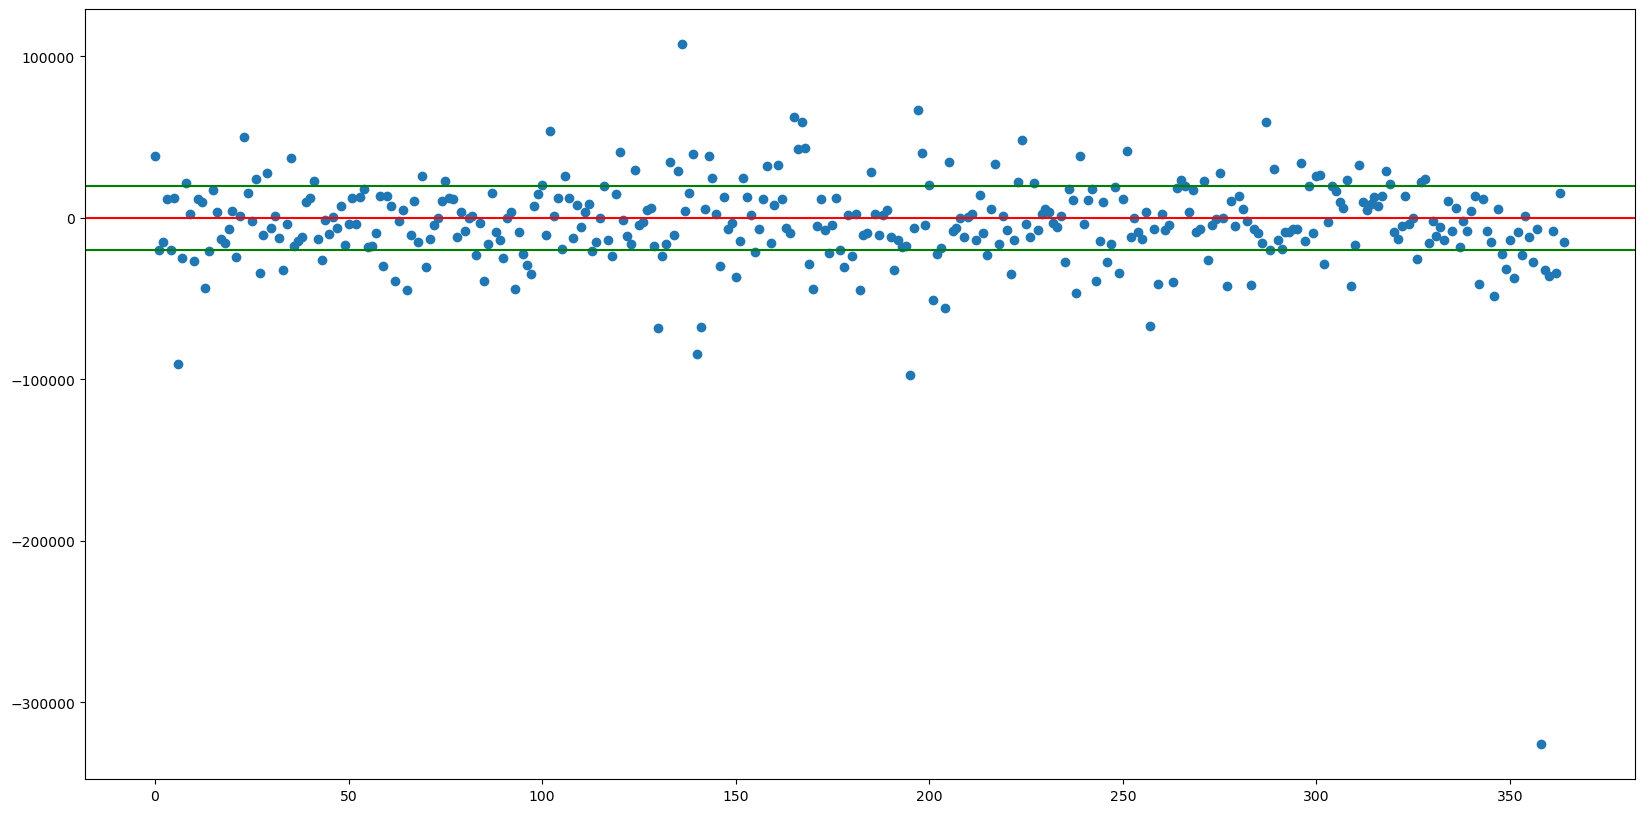

In [138]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(y_test1)), svr.predict(X_test1_s) - y_test1)
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

In [139]:
ridge = Ridge(alpha=22.9, 
      fit_intercept=True, 
      copy_X=True, 
      max_iter=None, 
      tol=0.0001, 
      solver='auto', 
      positive=False, 
      random_state=42)

In [140]:
ridge.fit(X_train1_s, y_train1)

Ridge(alpha=22.9, random_state=42, tol=0.0001)

In [141]:
ridge_preds = ridge.predict(X_test1_s)

In [142]:
np.sqrt(mean_squared_error(ridge.predict(X_test1_s), y_test1))

30909.855541398378

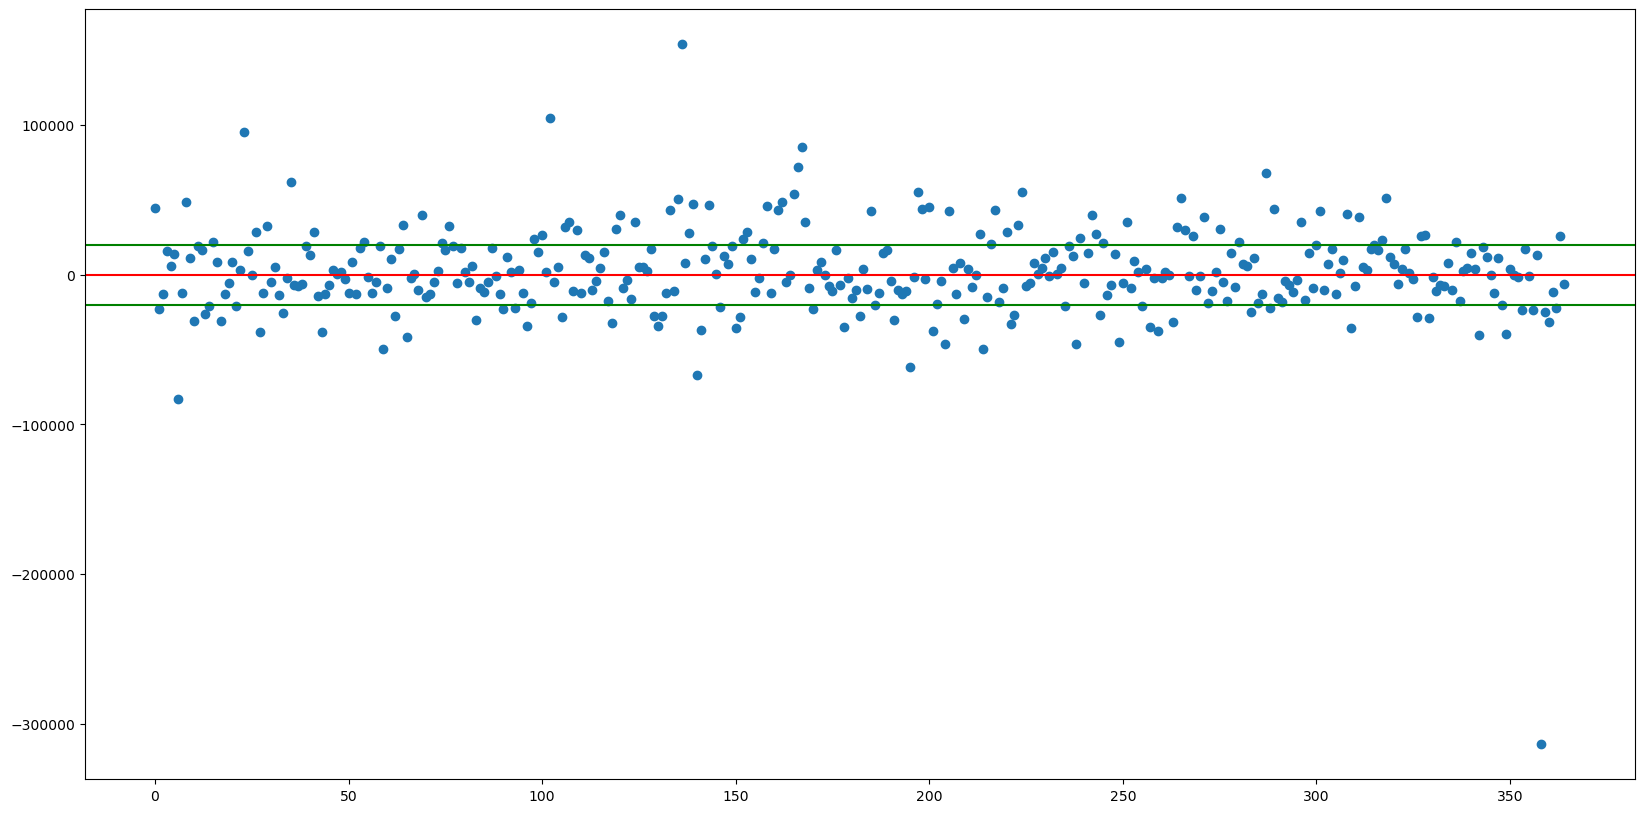

In [143]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(y_test1)), ridge.predict(X_test1_s) - y_test1)
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

### XGboost

In [144]:
model_xgb = xgboost.XGBRegressor(max_depth=3, 
                                 booster="gbtree", 
                                 learning_rate=0.1, 
                                 subsample=0.3, 
                                 reg_lambda=5, 
                                 n_estimators=100)
model_xgb.fit(X_train1_s, y_train1)
test_predictions = model_xgb.predict(X_test1_s)

np.sqrt(mean_squared_error(y_test1, test_predictions))

23970.142185901652

In [145]:
np.sqrt(mean_squared_log_error(model_xgb.predict(X_test1_s), y_test1))

0.12817053512935492

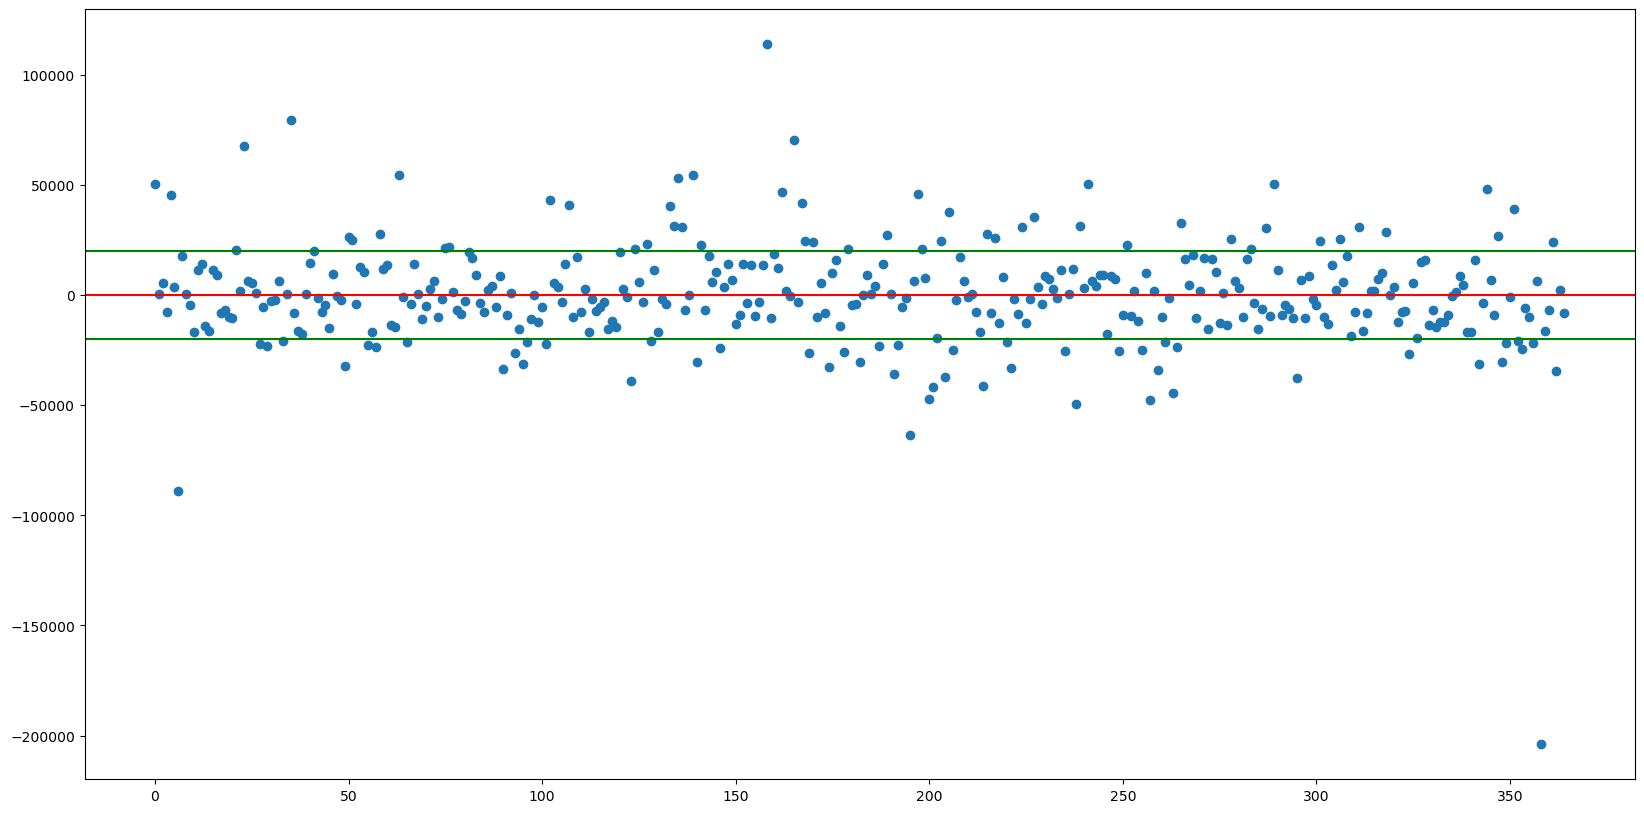

In [146]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(y_test1)), model_xgb.predict(X_test1_s) - y_test1)
plt.axhline(0, c='r')
plt.axhline(20000, c='g')
plt.axhline(-20000, c='g')

## An attempt to ensemble learning

In [488]:
test = pd.read_csv('test_preprocessed.csv')

In [489]:
test.shape

(1459, 78)

### CatBoost

In [490]:
X, y = prepare_and_split_data(train)
sub_train_pool = Pool(X, y, 
                 cat_features=cat_features)


In [491]:
X.shape

(1458, 78)

In [492]:
# catboost
model.fit(sub_train_pool)
preds_catboost = model.predict(test)

0:	learn: 52572.5760868	total: 1.79ms	remaining: 1.79s
100:	learn: 15474.3934416	total: 130ms	remaining: 1.16s
200:	learn: 13249.3006935	total: 245ms	remaining: 974ms
300:	learn: 12276.0171442	total: 353ms	remaining: 819ms
400:	learn: 11586.8355020	total: 468ms	remaining: 699ms
500:	learn: 11131.8798871	total: 575ms	remaining: 573ms
600:	learn: 10799.5476545	total: 688ms	remaining: 457ms
700:	learn: 10513.4866373	total: 797ms	remaining: 340ms
800:	learn: 10224.5101396	total: 910ms	remaining: 226ms
900:	learn: 9995.1682389	total: 1.05s	remaining: 116ms
999:	learn: 9768.6605726	total: 1.19s	remaining: 0us


### Other models (not CatBoost)

In [539]:
test = pd.read_csv('test_preprocessed.csv')

In [540]:
def data_preprocessing(data_train):
    X_train = data_train.drop('SalePrice', axis=1)
    y_train = data_train['SalePrice']
    
    categories = []
    for col in data_train.columns:
        if data_train[col].dtype == 'object':
            categories.append(col)
            #print(len(categories))
#     ohe = OneHotEncoder(handle_unknown='ignore')#(handle_unknown='infrequent_if_exist')
#     ohe.fit(X_train[categories])
#     cat_features_df = pd.DataFrame(ohe.transform(X_train[categories]).toarray(), 
#                                    index=X_train.index, 
#                                    columns=ohe.get_feature_names_out())
    X_train.drop(categories, axis=1, inplace=True)
#     X = X_train.join(cat_features_df)

    return X, y_train

In [541]:
X, y_train = data_preprocessing(train)

In [542]:
X.shape

(1458, 241)

In [543]:
def data_preprocessing(data_train):
    X_train = data_train
    
    categories = []
    for col in data_train.columns:
        if data_train[col].dtype == 'object':
            categories.append(col)
            #print(len(categories))
#     ohe = OneHotEncoder(handle_unknown='ignore')#(handle_unknown='infrequent_if_exist')
#     ohe.fit(X_train[categories])
#     cat_features_df = pd.DataFrame(ohe.transform(X_train[categories]).toarray(), 
#                                    index=X_train.index, 
#                                    columns=ohe.get_feature_names_out())
    X_train.drop(categories, axis=1, inplace=True)
#     X = X_train.join(cat_features_df)

    return X

In [544]:
X_final = data_preprocessing(test)

In [545]:
X_final.shape

(1458, 241)

In [549]:
scaler.fit(X)
X_s = scaler.transform(X)
scaler.fit(X_final)
X_final_s = scaler.transform(X_final)

In [550]:
# lasso
lasso.fit(X_s, y)
preds_lasso = lasso.predict(X_final_s)

In [551]:
# xgboost
model_xgb.fit(X_s, y)
preds_xgboost = model_xgb.predict(X_final_s)

In [552]:
# svr
svr.fit(X_s, y)
preds_svr = svr.predict(X_final_s)

C:\Soft\Anaconda\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [553]:
# ridge
ridge.fit(X_s, y)
preds_ridge = ridge.predict(X_final_s)

In [577]:
# mse

weights = pd.DataFrame([20651, 32261, 30910, 23970, 29480],['catboost', 'lasso', 'ridge', 'xgboost', 'svr'])

weights['inverted'] = 1/ weights[0]

weights = weights['inverted'] / sum(weights['inverted'])
weights

catboost    0.258380
lasso       0.165395
ridge       0.172624
xgboost     0.222604
svr         0.180998
Name: inverted, dtype: float64

In [592]:
preds = pd.DataFrame([preds_catboost, preds_lasso, preds_ridge, preds_xgboost, preds_svr])
preds

0              1              2              3              4     \
0  129632.293089  158763.271280  183355.134525  195440.394609  184397.409894   
1  213389.992268  199036.501178  206265.541336  172633.050570  273959.064954   
2  213333.813741  197787.335640  206963.812486  171841.020563  273515.954100   
3  200711.593750  179255.890625  217436.875000  174023.421875  299965.437500   
4  204637.239182  184850.813476  211272.774375  171089.941840  269901.662599   

            5              6              7              8              9     \
0  174161.422425  178042.110594  162744.675912  199383.525660  128326.402995   
1  147901.294130  277432.336973  234474.413112  132876.446142  116239.382281   
2  148871.926087  277410.015688  232607.762306  132610.682394  115476.649859   
3  153787.000000  308459.437500  209712.750000  143456.265625  124721.593750   
4  146452.732528  267425.715874  231104.228843  131383.671346  130187.377660   

            10             11             12             13             14    \
0  189329.016373   99136.640666   98633.866442  147719.561793  120379.803002   
1  131334.699978  370609.726468  138977.405878  245172.052719  163970.252482   
2  131200.209861  370402.750575  137868.224782  245760.380657  163730.422414   
3  124847.578125  358066.531250  133818.078125  224150.343750  154792.093750   
4  121741.548210  341710.276098  128822.766091  238318.074889  158927.283395   

            15             16             17             18             19    \
0  359997.780207  260058.282188  301010.168474  291109.276164  488306.936141   
1  131674.496533  159172.672055  106026.670802  142879.263184  125548.978294   
2  131478.195128  158272.954150  105173.972675  143122.832396  125488.115808   
3  146270.328125  142655.468750  110812.468750  159081.484375  129424.421875   
4  134485.443828  152636.866107   99806.705604  151714.800763  126760.653330   

            20             21             22             23             24    \
0  294924.889017  204740.763015  166059.768279  161952.008673  180374.593382   
1  316481.519021  118563.340688  234674.459478  142882.187864  142275.211365   
2  317213.893286  119552.840099  234989.127981  143377.604937  143795.789141   
3  333999.500000  134765.468750  230511.187500  134450.250000  144297.156250   
4  298242.489984  130415.853528  232990.761832  141622.530176  142452.636277   

            25             26             27             28             29    \
0  196266.898434  321088.069705  236660.496390  208004.550894  236823.312176   
1  263266.151175  130108.065536  284106.014333  225948.111348   64736.174399   
2  263183.877312  130169.131273  283560.307617  225244.429242   64914.930419   
3  266890.437500  132192.171875  324213.031250  192594.140625   70106.781250   
4  256724.031749  128953.278060  273773.436635  203034.283075   67099.207492   

            30             31             32             33             34    \
0  189824.564007  103458.209760  181957.891213  293936.428460  289433.358535   
1   74419.676861  142008.889200  196571.020382  183105.114392  275855.337786   
2   73133.974413  142135.656008  196252.371183  184970.825724  276204.047161   
3   76302.015625  139409.546875  193503.796875  174590.640625  279005.531250   
4   74498.152405  126790.241211  185254.944917  184768.809617  260131.329782   

            35             36             37             38             39    \
0  242051.294139  186212.574573  159359.532799  158288.520331  146265.446414   
1  300491.084874  148457.168364  173248.145688  134988.691355   89582.453704   
2  299833.132116  149008.154001  172809.592534  134548.457018   87460.541537   
3  309237.812500  151858.843750  151993.203125  133868.765625   74607.921875   
4  282784.860720  148885.155480  171282.577681  132519.035272   92851.091946   

            40             41             42             43             44    \
0  174306.923765  148822.004402  290007.917223  244001.932879  221641.299893   
1  1

In [593]:
preds = preds.T
preds

,0,1,2,3,4
0,129632.293089,213389.992268,213333.813741,200711.593750,204637.239182
1,158763.271280,199036.501178,197787.335640,179255.890625,184850.813476
2,183355.134525,206265.541336,206963.812486,217436.875000,211272.774375
3,195440.394609,172633.050570,171841.020563,174023.421875,171089.941840
4,184397.409894,273959.064954,273515.954100,299965.437500,269901.662599
...,...,...,...,...,...
1454,82609.006708,224815.158446,224287.786090,198338.578125,215841.670397
1455,84043.966910,262190.547923,259810.451438,254729.093750,249953.852488
1456,161218.266510,151516.988391,151439.337118,138439.859375,146573.790496
1457,121440.246789,155755.891401,156353.354179,149124.343750,150710.691533


In [608]:
preds['final'] = preds.median(axis = 1)
preds

,0,1,2,3,4,final
0,129632.293089,213389.992268,213333.813741,200711.593750,204637.239182,202674.416466
1,158763.271280,199036.501178,197787.335640,179255.890625,184850.813476,182053.352051
2,183355.134525,206265.541336,206963.812486,217436.875000,211272.774375,206614.676911
3,195440.394609,172633.050570,171841.020563,174023.421875,171089.941840,172237.035566
4,184397.409894,273959.064954,273515.954100,299965.437500,269901.662599,271708.808349
5,174161.422425,147901.294130,148871.926087,153787.000000,146452.732528,148871.926087
6,178042.110594,277432.336973,277410.015688,308459.437500,267425.715874,277410.015688
7,162744.675912,234474.413112,232607.762306,209712.750000,231104.228843,231104.228843
8,199383.525660,132876.446142,132610.682394,143456.265625,131383.671346,132876.446142
9,128326.402995,116239.382281,115476.649859,124721.593750,130187.377660,124721.593750


In [609]:
nan_count = preds['final'].isna().sum()
nan_count

0

In [605]:
pd.set_option('display.max_rows', None)

### Submission

In [493]:
X, y = prepare_and_split_data(train)

In [152]:
sub_train_pool = Pool(X, y, 
                 cat_features=cat_features)

In [153]:
model.fit(sub_train_pool)
preds = model.predict(test)

0:	learn: 52572.5760868	total: 1.77ms	remaining: 1.77s
100:	learn: 15474.3934416	total: 146ms	remaining: 1.3s
200:	learn: 13249.3006935	total: 261ms	remaining: 1.04s
300:	learn: 12276.0171442	total: 372ms	remaining: 863ms
400:	learn: 11586.8355020	total: 499ms	remaining: 746ms
500:	learn: 11131.8798871	total: 608ms	remaining: 606ms
600:	learn: 10799.5476545	total: 722ms	remaining: 479ms
700:	learn: 10513.4866373	total: 833ms	remaining: 355ms
800:	learn: 10224.5101396	total: 980ms	remaining: 243ms
900:	learn: 9995.1682389	total: 1.11s	remaining: 122ms
999:	learn: 9768.6605726	total: 1.24s	remaining: 0us


In [209]:
test = pd.read_csv('test_preprocessed.csv')

In [155]:
preds = model.predict(test)

In [156]:
preds

array([129632.29308877, 158763.27128026, 183355.13452465, ...,
       161218.26651025, 121440.24678895, 217120.18312224])

In [610]:
test_id = pd.read_csv('test.csv')

In [611]:
sub_test = test_id.copy()

In [612]:
sub_test['SalePrice'] = pd.Series(preds['final'])

### Output

In [613]:
sub_test[['Id', 'SalePrice']].to_csv('out.csv', index=False)